In [84]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from python_speech_features import mfcc

# Filename identifiers

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [85]:
emotion_labels = {
    "01": 'neutral',
    "02": 'calm',
    "03": 'happy',
    "04": 'sad',
    "05": 'angry',
    "06": 'fearful',
    "07": 'disgust',
    "08": 'surprised'
}


def load_data(dataset_path):
    emotions = []
    features = []
    for file in glob.glob(dataset_path + 'Actor_*/*.wav'):
        emotion = extract_emotion_from_filename(os.path.basename(file))
        feature = extract_features(file)
        emotions.append(emotion)
        features.append(feature)
    return np.array(features), np.array(emotions)

def extract_emotion_from_filename(filename):
    emotion_code = filename.split('-')[2]
    return emotion_labels[emotion_code]

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

    frame_len = int(2 ** np.floor(np.log2(0.03 * sample_rate)))

    mfccs = mfcc(audio, 
                 sample_rate, 
                 winlen=frame_len / sample_rate, 
                 winstep=frame_len / (2 * sample_rate), 
                 numcep=12,
                 winfunc=numpy.hamming)
    mfccs_scaled = np.mean(mfccs, axis=0)
    return mfccs_scaled

In [86]:
dataset_path = 'ravdess/'
features, emotions = load_data(dataset_path)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(features, emotions, test_size=0.2, random_state=42)

print(f'{len(X_train)} samples in training set')
print(f'{len(X_test)} samples in testing set')

1152 samples in training set
288 samples in testing set


In [88]:

classifiers = {
    'SVM': SVC(kernel='poly'),
    'Random Forest': RandomForestClassifier(random_state=0),
    'KNN': KNeighborsClassifier()
}

results = {}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

Results for SVM:
Accuracy: 0.4826388888888889
Precision: 0.5260496203768383
Recall: 0.4826388888888889
F1 Score: 0.4826231776772889
Confusion Matrix:


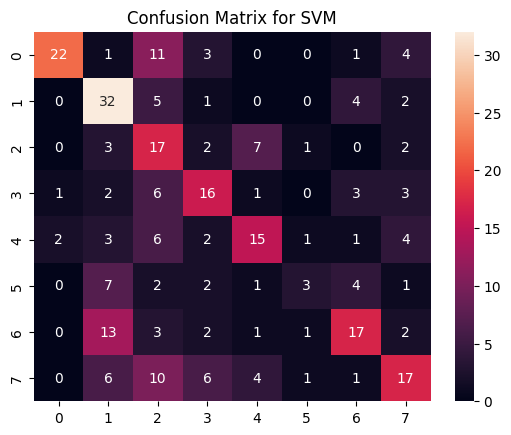

Results for Random Forest:
Accuracy: 0.5590277777777778
Precision: 0.5737740425770088
Recall: 0.5590277777777778
F1 Score: 0.5589185009507156
Confusion Matrix:


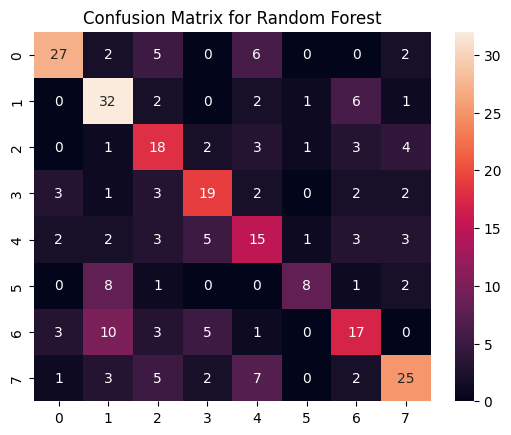

Results for KNN:
Accuracy: 0.5381944444444444
Precision: 0.535996753197551
Recall: 0.5381944444444444
F1 Score: 0.5284349234679596
Confusion Matrix:


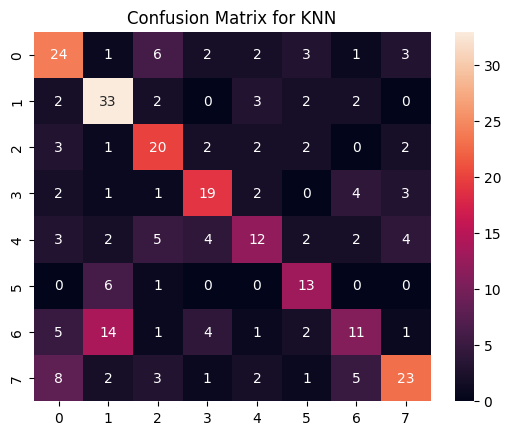

In [89]:
for name, metrics in results.items():
    print(f"Results for {name}:")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1_score']}")
    print("Confusion Matrix:")
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()